## CYCLE-GAN
## GOAL: Ageing experiment

In [0]:
import keras
import tensorflow as tf

import os
import keras.backend as K
K.set_image_data_format('channels_last')
channel_axis=-1
channel_first = False

Using TensorFlow backend.


In [0]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

In [0]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization

### Building basic discriminator model

In [0]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def discriminator_model(nc_in, ndf, max_layers=3, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a =  Input(shape=(nc_in, None, None))
    else:
        input_a = Input(shape=(None, None, nc_in))
    _ = input_a
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid" if use_sigmoid else None) (_)    
    return Model(inputs=[input_a], outputs=_)

### Building generator using UNET model

In [0]:
def UNET_generator_model(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

#### Declaring parameters

In [0]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
use_lsgan = True
λ = 10 if use_lsgan else 100

loadSize = 143 
imageSize = 128 
batchSize = 1
lrD = 2e-4
lrG = 2e-4

### Cycle GAN

- requires two image distributions say `A` and `B` where our goal is to move from one distribution to another
- `A` is for young age images and `B` is for old age images
- requires two sets of discriminators and generators

#### Generator

- `GB`: takes in `young age` images to generate good quality `old age` images
- `GA`: takes in `old age` images to generate good quality `young age` images


#### Discriminator

- Goal of  `DA` is to discriminate between real and fake `young age` images
- Goal of `DB` to discriminate between real and fake `old age` images


#### Let's define discriminator and generator models for cycle gan as follows: `modDA, modDB, modGA, modGB` 

In [0]:
modDA = discriminator_model(nc_in, ndf, use_sigmoid = not use_lsgan)
modDB = discriminator_model(nc_out, ndf, use_sigmoid = not use_lsgan)
modDA.summary()

W0818 09:45:29.154629 140016556619648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 09:45:29.193813 140016556619648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 09:45:29.202003 140016556619648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0818 09:45:29.250416 140016556619648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0818 09:45:29.251231 140016556619

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
First (Conv2D)               (None, None, None, 64)    3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, None, 64)    0         
_________________________________________________________________
pyramid.1 (Conv2D)           (None, None, None, 128)   131072    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 128)   512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, None, None, 128)   0         
_________________________________________________________________
pyramid.2 (Conv2D)           (None, None, None, 256)   524288    
__________

In [0]:


modGB = UNET_generator_model(imageSize, nc_in, nc_out, ngf)
modGA = UNET_generator_model(imageSize, nc_out, nc_in, ngf)

modGA.summary()

W0818 09:45:36.935219 140016556619648 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv_128 (Conv2D)               (None, 64, 64, 64)   3136        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 64, 64, 64)   0           conv_128[0][0]                   
__________________________________________________________________________________________________
conv_64 (Conv2D)                (None, 32, 32, 128)  131072      leaky_re_lu_15[0][0]             
__________________________________________________________________________________________________
batch_norm

In [0]:
from keras.optimizers import RMSprop, SGD, Adam

In [0]:
if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

def cycle_variables(netG1, netG2):
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]
    rec_input = netG2([fake_output])
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate

real_A, fake_B, rec_A, cycleA_generate = cycle_variables(modGB, modGA)
real_B, fake_A, rec_B, cycleB_generate = cycle_variables(modGA, modGB)

In [0]:
def D_loss(netD, real, fake, rec):
    output_real = netD([real])
    output_fake = netD([fake])
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    loss_D = loss_D_real+loss_D_fake
    loss_cyc = K.mean(K.abs(rec-real))
    return loss_D, loss_G, loss_cyc

loss_DA, loss_GA, loss_cycA = D_loss(modDA, real_A, fake_A, rec_A)
loss_DB, loss_GB, loss_cycB = D_loss(modDB, real_B, fake_B, rec_B)
loss_cyc = loss_cycA+loss_cycB

In [0]:
loss_G = loss_GA+loss_GB+λ*loss_cyc
loss_D = loss_DA+loss_DB

weightsD = modDA.trainable_weights + modDB.trainable_weights
weightsG = modGA.trainable_weights + modGB.trainable_weights

training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_DA/2, loss_DB/2], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsG,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_GA, loss_GB, loss_cyc], training_updates)

In [0]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern,recursive=True)

def read_image(fn):
    im = Image.open(fn).convert('RGB')
    im = im.resize( (loadSize, loadSize), Image.BICUBIC )
    arr = np.array(im)/255*2-1
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    img = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    return img



### DATASET for Ageing Experiment

- `testA` contains photos of younger age people
- `testB` contains photos of old aged people

In [0]:
!unzip testA.zip
!unzip testB.zip

In [0]:
train_A = load_data('/content/testA/*')
train_B = load_data('/content/testB/*')

assert len(train_A) and len(train_B)

In [0]:
print("A:", len(train_A))
print("B:", len(train_B))

A: 3404
B: 2592


Helper functions to generate batches for both the image groups.

In [0]:
def minibatch(data, batchsize):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_image(data[j]) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       

def minibatchAB(dataA, dataB, batchsize):
    batchA=minibatch(dataA, batchsize)
    batchB=minibatch(dataB, batchsize)
    tmpsize = None    
    while True:        
        ep1, A = batchA.send(tmpsize)
        ep2, B = batchB.send(tmpsize)
        tmpsize = yield max(ep1, ep2), A, B

In [0]:
from IPython.display import display
def showX(X, rows=1):
    #print(X.shape)
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
        
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    #print(int_X.shape)
    display(Image.fromarray(int_X))

Showing 6 samples from each of the two age groups

(6, 128, 128, 3)


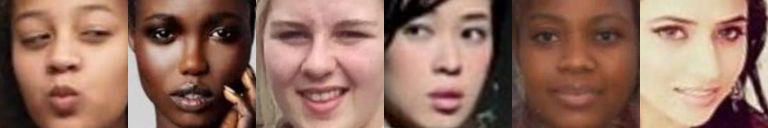

(6, 128, 128, 3)


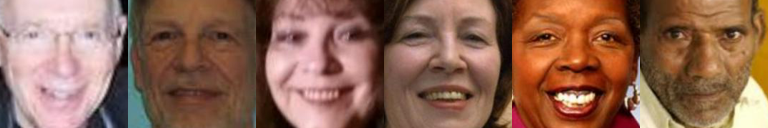

In [0]:
train_batch = minibatchAB(train_A, train_B, 6)

_, A, B = next(train_batch)
showX(A)
showX(B)
del train_batch, A, B

In [0]:
def showG(A,B):
    assert A.shape==B.shape
    def G(fn_generate, X):
        r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
        return r.swapaxes(0,1)[:,:,0]        
    rA = G(cycleA_generate, A)
    rB = G(cycleB_generate, B)
    arr = np.concatenate([A,B,rA[0],rB[0],rA[1],rB[1]])
    showX(arr, 3)

### TRAINING MODE

#### Training both sets of generator and discriminator models for 100 epochs

- During training we are displaying 4 images from `young age` dataset and 4 from `old age` dataset along with their respective translated images and reconstructed images.

[99/100] Loss_D: 0.159985 0.118693 Loss_G: 0.453092 0.542599 loss_cyc 0.053489 428.98605012893677
(24, 128, 128, 3)


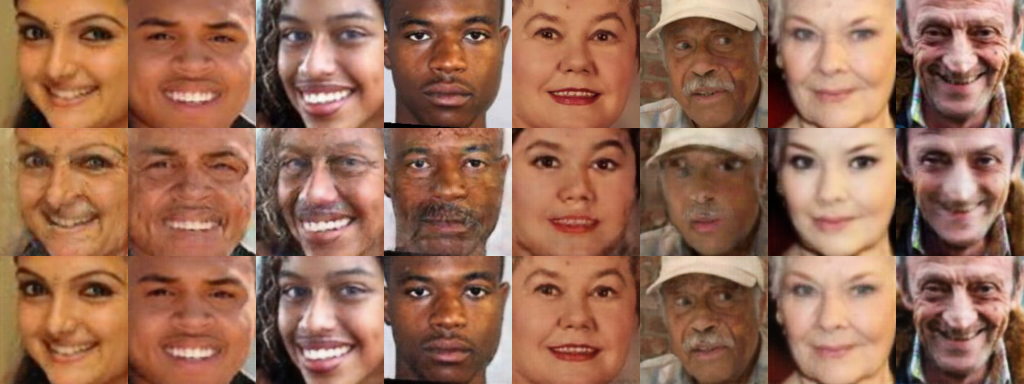

In [0]:
import time
from IPython.display import clear_output

t0 = time.time()

epochs = 100
run_count = 0
epoch = 0

errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

display_iters = 100

train_batch = minibatchAB(train_A, train_B, batchSize)

while epoch < epochs: 
    epoch, A, B = next(train_batch)        
    errDA, errDB  = netD_train([A, B])
    errDA_sum +=errDA
    errDB_sum +=errDB

  
    errGA, errGB, errCyc = netG_train([A, B])
    errGA_sum += errGA
    errGB_sum += errGB
    errCyc_sum += errCyc
    run_count+=1

        
    if run_count%display_iters==0:
       
        clear_output()
        print('[%d/%d] Loss_D: %f %f Loss_G: %f %f loss_cyc %f'
        % (epoch, epochs,errDA_sum/display_iters, errDB_sum/display_iters,
           errGA_sum/display_iters, errGB_sum/display_iters, 
           errCyc_sum/display_iters), time.time()-t0)
        _, A, B = train_batch.send(4)
        showG(A,B)        
        errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

#### Saving model and model weights. Helps in training with breaks

In [0]:
modDA.save("modDA_model_cycgan_final.h5")
modDB.save("modDB_model_cycgan_final.h5")
modGA.save("modGA_model_cycgan_final.h5")
modGB.save("modGB_model_cycgan_final.h5")

In [0]:
modDA.save_weights("modDA_cycgan_final.h5")
modDB.save_weights("modDB_cycgan_final.h5")
modGA.save_weights("modGA_cycgan_final.h5")
modGB.save_weights("modGB_cycgan_final.h5")

### This is where we stopped!

[99/100] Loss_D: 0.159985 0.118693 Loss_G: 0.453092 0.542599 loss_cyc 0.053489 428.98605012893677

### INFERENCE MODE

Finally we are using our trained model weights to check out few images from each of the age group:

Results demonstrates how image of a `young` person can be translated into images of his/her `old self` using the `generator B modGB`.

And same can be observed for `old aged` people. They too can be shown in their `younger version` using the `generator A modGA` 

In [0]:
modDA.load_weights("modDA_cycgan_final.h5")
modDB.load_weights("modDB_cycgan_final.h5")
modGA.load_weights("modGA_cycgan_final.h5")
modGB.load_weights("modGB_cycgan_final.h5")


Young --> Old
Image No: 1


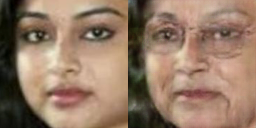

Image No: 2


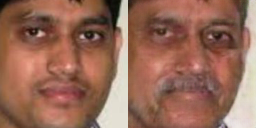

Image No: 3


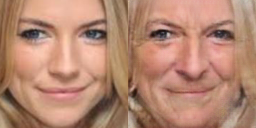

In [0]:

import argparse
from PIL import Image
import numpy as np
import os
import keras.backend as K
from keras.models import model_from_json
os.environ['KERAS_BACKEND']='tensorflow' 


def generate_function(netG):
    real_input = netG.inputs[0]
    fake_output = netG.outputs[0]  
    fn_generate = K.function([real_input], [fake_output])
    return fn_generate

def generate_imgs(input_dir, output_dir, generator):
    i=1
    for img_file in os.listdir(input_dir):
        print("Image No:", i)
        img = read_image(os.path.join(input_dir, img_file))
        fake_img = generator([img.reshape(1,128,128,3)])[0][0]
        arr = np.concatenate([img,fake_img])
        showX(arr, 1)
        fake_img = Image.fromarray(((fake_img+1)/2*255).clip(0,255).astype('uint8'))
        i=i+1

#### GENERATING older age version of young age photos i.e. MOVING FROM IMAGE DISTRIBUTION A TO IMAGE DISTRIBUTION B

generate_a2b = generate_function(modGB)

#### GENERATING younger age version of old aged photos i.e. MOVING FROM IMAGE DISTRIBUTION B TO IMAGE DISTRIBUTION A

generate_b2a = generate_function(modGA)

print("Young --> Old")
generate_imgs('test/v1/', 'test/', generate_a2b)

Old --> Young
Image No: 1


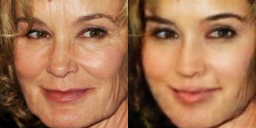

Image No: 2


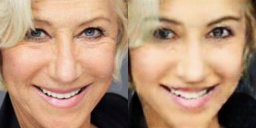

Image No: 3


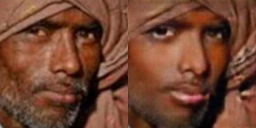

Image No: 4


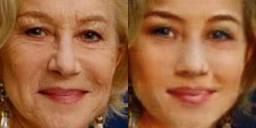

Image No: 5


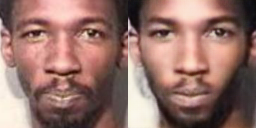

Image No: 6


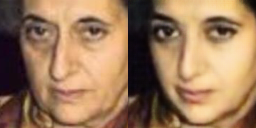

Image No: 7


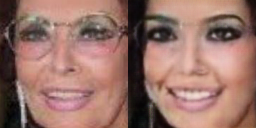

Image No: 8


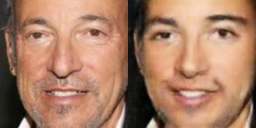

In [0]:
print("Old --> Young")
generate_imgs('test/v2/', 'test/', generate_b2a)